In [70]:
#Importing the required libraries
import csv
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

<span style="font-size:40px;">Data Processing</span>


In [71]:
#Fetching the csv file
data_train=pd.read_csv('data_train.csv') 

#Printing the first 5 rows of the dataset
print(data_train.head())

print('\n')
#Printing the shape of the dataset
print(f'The shape of the data set is {data_train.shape}')

   Unnamed: 0  PT08.S1(CO)  NMHC(GT)  C6H6(GT)  PT08.S2(NMHC)  NOx(GT)  \
0           0        797.0    -200.0       2.1          593.0    146.0   
1           1       1282.0    -200.0      11.0         1013.0    354.0   
2           2        891.0    -200.0       7.6          882.0    342.0   
3           3       1285.0    -200.0      18.1         1243.0    481.0   
4           4        892.0    -200.0       7.3          869.0     71.0   

   PT08.S3(NOx)  NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)     T    RH      AH  
0        1212.0     72.0         984.0        494.0  10.8  49.7  0.6429  
1         545.0    141.0        1384.0       1287.0  17.4  50.6  0.9989  
2         885.0    149.0         950.0        894.0   7.8  33.9  0.3594  
3         599.0    173.0        1815.0       1582.0  26.4  41.9  1.4237  
4         953.0     77.0        1363.0        632.0  37.4  14.7  0.9295  


The shape of the data set is (6250, 13)


#Description of the data


The dataset consists of 6250 samples, each with 13 attributes. These attributes consists of measurements of air quality pollutants which includes carbon monoxide (CO), non-methane hydrocarbons (NMHC), benzene (C6H6), nitrogen oxides (NOx), nitrogen dioxide (NO2), and ozone (O3), recorded in parts per billion (ppb) and micrograms per cubic meter (μg/m³). Additionally, the dataset includes ambient temperature (in Celsius), relative humidity (RH), and absolute humidity (AH) values. This dataset offers a valuable insight into the air composition and environmental conditions, enabling analysis of pollutant levels and their correlations with temperature and humidity for assessing air quality and potential health impacts.

In [72]:
#checking the null values in the dataset
data_train.isnull().sum()
print('Yes, the dataset has null values')
print('Each attributes has 77 null values')


Yes, the dataset has null values
Each attributes has 77 null values


#Null values details

Unnamed: 0        0
PT08.S1(CO)      77
NMHC(GT)         77
C6H6(GT)         77
PT08.S2(NMHC)    77
NOx(GT)          77
PT08.S3(NOx)     77
NO2(GT)          77
PT08.S4(NO2)     77
PT08.S5(O3)      77
T                77
RH               77
AH               77
dtype: int64

In [73]:
# Removing rows with any null values
data_train.dropna(axis=0, how='any', inplace=True)

# Reseting indices of the DataFrame
data_train.reset_index(drop=True, inplace=True)


In [74]:
# Extracting the features and labels
data_train_label = data_train['PT08.S1(CO)']
data_train_features = data_train.drop(['PT08.S1(CO)', 'Unnamed: 0'], axis=1)
print(data_train_features.head())

   NMHC(GT)  C6H6(GT)  PT08.S2(NMHC)  NOx(GT)  PT08.S3(NOx)  NO2(GT)  \
0    -200.0       2.1          593.0    146.0        1212.0     72.0   
1    -200.0      11.0         1013.0    354.0         545.0    141.0   
2    -200.0       7.6          882.0    342.0         885.0    149.0   
3    -200.0      18.1         1243.0    481.0         599.0    173.0   
4    -200.0       7.3          869.0     71.0         953.0     77.0   

   PT08.S4(NO2)  PT08.S5(O3)     T    RH      AH  
0         984.0        494.0  10.8  49.7  0.6429  
1        1384.0       1287.0  17.4  50.6  0.9989  
2         950.0        894.0   7.8  33.9  0.3594  
3        1815.0       1582.0  26.4  41.9  1.4237  
4        1363.0        632.0  37.4  14.7  0.9295  


In [75]:
#converting Data in Pandas dataframe
data_train_label = pd.Series(data_train_label)
data_train_features = pd.DataFrame(data_train_features)


<span style="font-size:40px;">Exploratory Data Analysis</span>

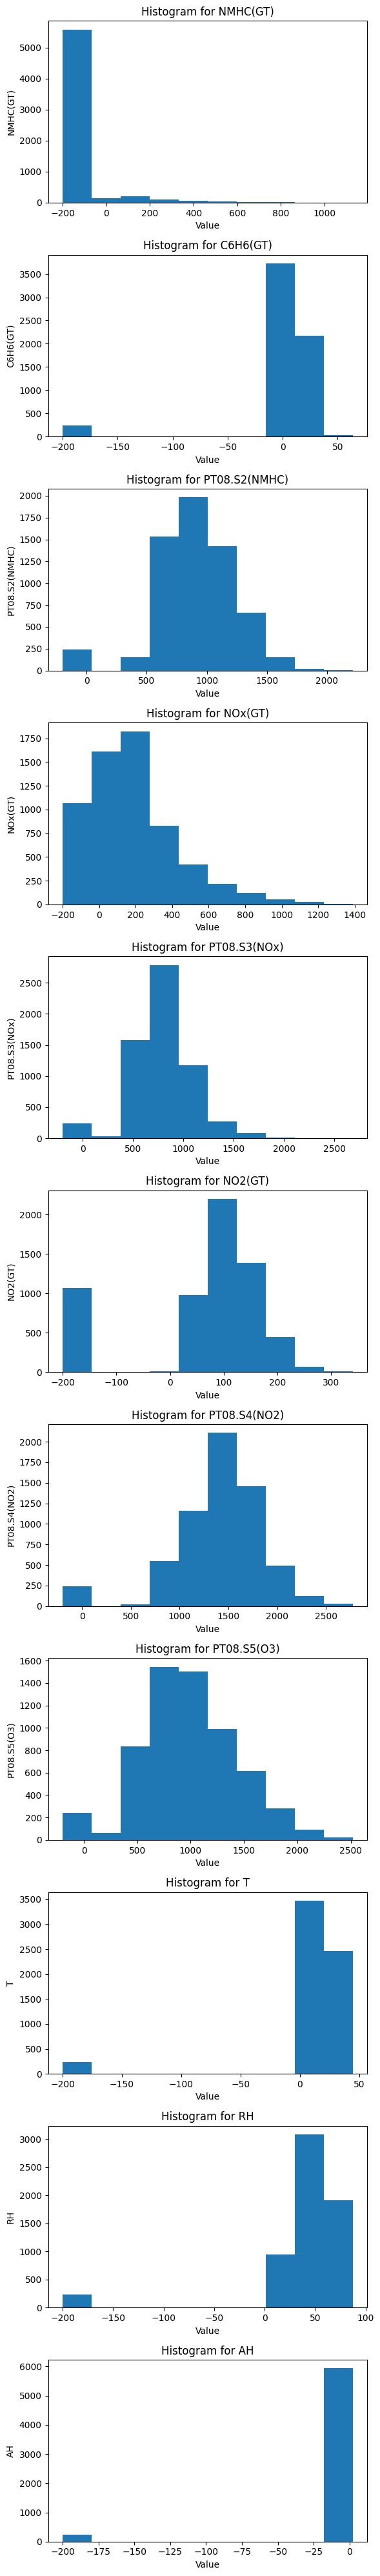

In [76]:
# Plotting histograms of all features
column_names=data_train_features.columns

fig, axes=plt.subplots(nrows=len(column_names), figsize=(6,40))

for i, column_name in enumerate(column_names):
        ax=axes[i]
        ax.hist(data_train_features[column_name])
        ax.set_ylabel(column_name)
        ax.set_xlabel('Value')
        ax.set_title(f'Histogram for {column_name}')

plt.tight_layout()
plt.show()

No, All features does not have normal distribution. Many attributes including AH, RH, temperature and NMHC does not have Normal distribution.

Yes, Outlier values are visible in AH,RH and temperature.

I will be doing Z-score normalization as it assumes the data has normal distribution and in the given dataset many attributes has that normalization. Also, Z-score normalization helps in easy detection of outliers.

In [77]:
# Normalizing the data using Standardization (Z-score normalization)
scaler = StandardScaler()
data_train_features = scaler.fit_transform(data_train_features)

data_train_features = pd.DataFrame(data_train_features, columns=column_names)
print(data_train_features.head())
 


   NMHC(GT)  C6H6(GT)  PT08.S2(NMHC)   NOx(GT)  PT08.S3(NOx)   NO2(GT)  \
0 -0.289465 -0.000142      -0.897650 -0.102472      1.319536  0.100477   
1 -0.289465  0.215773       0.326590  0.700381     -0.764693  0.645399   
2 -0.289465  0.133289      -0.055256  0.654063      0.297733  0.708578   
3 -0.289465  0.388020       0.997008  1.190585     -0.595954  0.898116   
4 -0.289465  0.126011      -0.093149 -0.391962      0.510218  0.139964   

   PT08.S4(NO2)  PT08.S5(O3)         T        RH        AH  
0     -0.892439    -1.065455  0.018263  0.198555  0.190639  
1     -0.034757     0.662205  0.171665  0.216202  0.199817  
2     -0.965342    -0.194000 -0.051465 -0.111244  0.183329  
3      0.889396     1.304903  0.380850  0.045616  0.210770  
4     -0.079785    -0.764803  0.636520 -0.487709  0.198028  


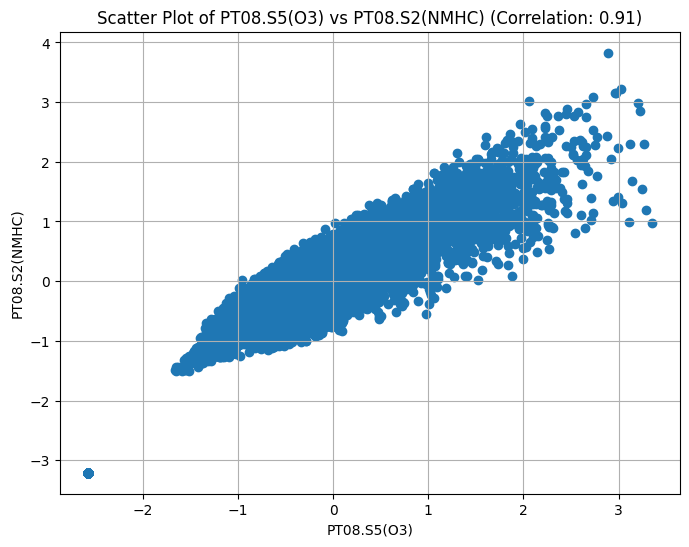

In [78]:
#Correlation between two features
#selected PT08.S5(O3) and PT08.S2(NMHC) to visualize the correlation between the features

# Computing correlation coefficient between the two features
correlation_coefficient = data_train_features.iloc[:, 7].corr(data_train_features.iloc[:, 2])

# Creating scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(data_train_features.iloc[:, 7], data_train_features.iloc[:, 2])
plt.title(f'Scatter Plot of PT08.S5(O3) vs PT08.S2(NMHC) (Correlation: {correlation_coefficient:.2f})')
plt.xlabel('PT08.S5(O3)')
plt.ylabel('PT08.S2(NMHC)')
plt.grid(True)
plt.show()



Yes there is high correlation between PT08.S5(O3) and PT08.S2(NMHC).

<class 'pandas.core.frame.DataFrame'>


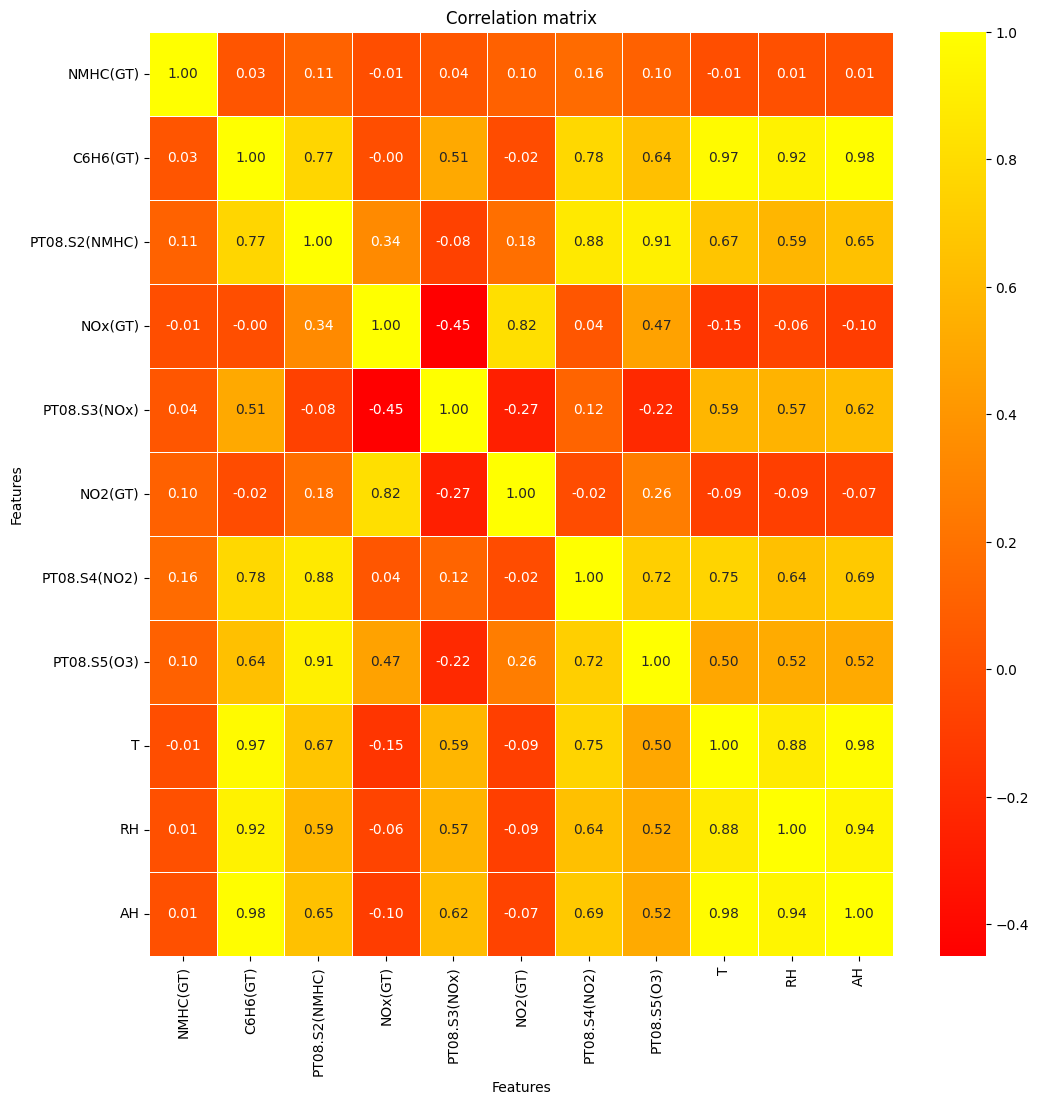

In [125]:
#Plotting the correlation matrix
temp_data = data_train_features
print(type(temp_data))
correlation_matrix = temp_data.corr()

#Plotting the heatmap
plt.figure(figsize=(12,12))
sns.heatmap(correlation_matrix, annot=True, cmap='autumn', fmt=".2f", linewidths=0.5)
plt.title('Correlation matrix')
plt.xlabel('Features')
plt.ylabel('Features')
plt.show()

In above heatmap, brighter yellow color represents positive correlation between the attributes and red color represents negative corelation between the attributes. 
For example, there is high postive correlation between AH and RH and temperature.
We can also see that if temperature is higher concentration of certaion gases such as NOx(GT),NO2(GT) reduces while that of C6H6 increases.
Above heatmap helps in efficient visualization between relationships between attributes.

<span style="font-size:40px;">Implementation of Linear regression without any python library</span>

In [132]:
#computing rmse
def compute_rmse(X, y, theta):
    m = len(y)
    predictions = np.dot(X, theta)
    squared_error = np.sum((predictions - y) ** 2)
    mean_squared_error = squared_error / m
    rmse = np.sqrt(mean_squared_error)
    return rmse

#function to add bias term
def add_bias_term(X):
    m = X.shape[0]  
    ones_column = np.ones((m, 1))  
    return np.concatenate((ones_column, X), axis=1)  

#function to perform linear regression using the closed form solution
def linear_regression_closed_form(X, y):
    theta = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
    return theta
#function to perform linear regression 
def predict_lin_reg(X, theta):
    return np.dot(X, theta)



I have implemented the linear regression solution by using a closed-form solution. Generally, a closed-form solution is an equation which can be solved in terms of functions and mathematical operations. In a nutshell, we take the derivative of the loss minimization function, set it equal to zero, and find the optimal value for the weights and bias.


Firstly, I have defined a function to add a bias term into the feature matrix.



$\textbf{add\_bias\_term}$: Function defined to add bias term in the feature matrix


Let $ X $ be the feature matrix with dimensions $ m \times n $, where  $m $ is the number of samples and $ n $ is the number of features. The function adds a bias term by concatenating a column of ones to $ X $, resulting in a new feature matrix $ X' $ with dimensions $m \times (n+1) $. Mathematically, this can be represented as:
$
\mathbf{X'} = \left[ \begin{array}{ccccc}
1 & X_{1,1} & X_{1,2} & \ldots & X_{1,n} \\
1 & X_{2,1} & X_{2,2} & \ldots & X_{2,n} \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
1 & X_{m,1} & X_{m,2} & \ldots & X_{m,n}
\end{array} \right]
$


$\textbf{linear\_regression\_closed\_form}$: Function defined to perform linear regression using the closed-form solution


Given the feature matrix $ X $ with the bias term added and the target vector $ y $, the function computes the optimal parameters $theta $ using the closed-form solution:
$
\theta = (X^T X)^{-1} X^T y.
$
Here, $ X^T$ denotes the transpose of $ X $, and $ (X^T X)^{-1}$ denotes the inverse of the matrix $X^T X $. The resulting $theta$ vector represents the coefficients of the linear regression model, including the intercept term.


$\textbf{predict\_lin\_reg}$: Function defined to predict linear regression output

To predict the output value, we take the dot product of the feature matrix (with bias term) with the calculated theta value.


$\textbf{compute\_rmse}$: Function defined to calculate RMSE value

Finally, I have defined this function to calculate rmse value which serves as the model performance evaluation matrix.





<span style="font-size:40px;">Implementation of Logistic regression without any python library</span>

In [97]:
#Implementing the logistic regression from scratch


train_label_lr = pd.DataFrame(data=0, index=range(len(data_train_label)), columns=['updated_label'])

# Assigning 1 to rows where the corresponding value in data_train_label is greater than 1000
for i in range(len(data_train_label)):
    if data_train_label[i] > 1000:
        train_label_lr.loc[i, 'updated_label'] = 1

print(train_label_lr)


      updated_label
0                 0
1                 1
2                 0
3                 1
4                 0
...             ...
6168              0
6169              0
6170              1
6171              0
6172              1

[6173 rows x 1 columns]


In [138]:
# Defining the sigmoid function
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# Defining the cost function
def compute_cost(X, y, theta):
    m = len(y)
    h = sigmoid(np.dot(X, theta))
    epsilon = 1e-5  # to avoid log(0)
    cost = (1 / m) * np.sum(-y * np.log(h + epsilon) - (1 - y) * np.log(1 - h + epsilon))
    return cost

# Defining the gradient descent function
def gradient_descent(X, y, theta, alpha, iterations):
    m = len(y)
    costs = []
    for _ in range(iterations):
        h = sigmoid(np.dot(X, theta))
        gradient = np.dot(X.T, (h - y)) / m
        theta -= alpha * gradient
        cost = compute_cost(X, y, theta)
        costs.append(cost)
    return theta, costs

$\textbf{compute\_cost}$: Cost function

<br>
The cost function is used to evaluate how well the defined model is predicting
match the actual labels. The mathematical representation of the cost function
is:


\begin{equation*}
J(\theta) = -\frac{1}{m} \sum_{i=1}^{m} [y^{(i)} \log(h_\theta(x^{(i)})) + (1 - y^{(i)}) \log(1 - h_\theta(x^{(i)}))]
\end{equation*}

Here:
\begin{align*}
    m & \text{ is the number of training examples.} \\
    y^{(i)} & \text{ is the actual label for the } i^{th} \text{ training example.} \\
    h_\theta(x^{(i)}) & \text{ is the predicted probability that } x^{(i)} \text{ belongs to class 1.} \\
    \theta & \text{ are the parameters of the model.}
\end{align*}

The sigmoid function is used to map any real-valued number into the range [0, 1], which represents the probability of the input belonging to class 1. It's defined as:
\begin{equation*}
\text{sigmoid}(z) = \frac{1}{1 + e^{-z}}
\end{equation*}
The epsilon term ($\epsilon$) is added to avoid taking the logarithm of zero, which would result in undefined behavior or numerical instability.

$\textbf{gradient\_descent}$: Gradient descent function

<br>
Gradient descent is used to minimize the cost function by adjusting the parameters theta. In each iteration, the parameters are updated in the direction of the steepest descent of the cost function. The update rule for gradient descent in logistic regression is:

\begin{equation*}
\theta_j = \theta_j - \alpha \frac{1}{m} \sum_{i=1}^{m} (h_\theta(x^{(i)}) - y^{(i)}) \cdot x_j^{(i)}
\end{equation*}

Where:

\begin{align*}
    \alpha & \text{ is the learning rate, determining the size of the steps taken during optimization.} \\
    m & \text{ is the number of training examples.} \\
    h_\theta(x^{(i)}) & \text{ is the predicted probability that } x^{(i)} \text{ belongs to class 1.} \\
    y^{(i)} & \text{ is the actual label for the } i^{th} \text{ training example.} \\
    x_j^{(i)} & \text{ is the } j^{th} \text{ feature value of the } i^{th} \text{ training example.} \\
    \theta_j & \text{ is the } j^{th} \text{ parameter (weight) of the model.}
\end{align*}

In each iteration, the cost is computed using the updated parameters, and the parameters are adjusted according to the gradient of the cost function with respect to each parameter. This process continues until convergence or until a specified number of iterations is reached.

In [134]:
# Defining the prediction function
def predict_log_reg(X, theta, threshold=0.5):
    return sigmoid(np.dot(X, theta)) >= threshold

# Metrics calculation function
def calculate_metrics(y_true, y_pred):
    tp = np.sum(np.logical_and(y_true == 1, y_pred == 1))
    tn = np.sum(np.logical_and(y_true == 0, y_pred == 0))
    fp = np.sum(np.logical_and(y_true == 0, y_pred == 1))
    fn = np.sum(np.logical_and(y_true == 1, y_pred == 0))
    
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if tp + fp > 0 else 0
    recall = tp / (tp + fn) if tp + fn > 0 else 0
    f1_score = 2 * precision * recall / (precision + recall) if precision + recall > 0 else 0
    
    return accuracy, precision, recall, f1_score

# Cross-validation function
def cross_validation(X, y, k=5, alpha=0.01, iterations=1000):
    num_folds = 5
    indices = np.arange(len(X))  
    np.random.shuffle(indices)  
    split = np.array_split(indices, num_folds)  

    accuracies = []
    precisions = []
    recalls = []
    f1_scores = []
    
    for i in range(k):

        test_indices = split[i]
        train_indices = np.concatenate(split[:i] + split[i + 1:])
        X_train = X.iloc[train_indices, 0:]
        y_train = y[train_indices]
        X_test = X.iloc[test_indices, 0:]
        y_test = y[test_indices]
        
        # Initializing theta
        theta = np.zeros(X_train.shape[1])
        # Performing gradient descent
        theta, _ = gradient_descent(X_train, y_train, theta, alpha, iterations)
        # Making predictions
        y_pred = predict_log_reg(X_test, theta)
        print(f'y_pred : {y_pred}')
        
        accuracy, precision, recall, f1_score = calculate_metrics(y_test, y_pred)
        accuracies.append(accuracy)
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1_score)

    print(f'The accuracy for the 5 folds are:{accuracies}')
    print(f'The precision for the 5 folds are:{precisions}')
    print(f'The recall for the 5 folds are:{recalls}')
    print(f'The f1_score for the 5 folds are:{f1_scores}')
    
    return {
        'accuracy': (np.mean(accuracies), np.std(accuracies)),
        'precision': (np.mean(precisions), np.std(precisions)),
        'recall': (np.mean(recalls), np.std(recalls)),
        'f1_score': (np.mean(f1_scores), np.std(f1_scores))
    }




<span style="font-size:40px;">Performing 5-fold cross validation for Linear Regression</span>

In [102]:
#Adding bias term to the feature matrix

data_train_features_bias = add_bias_term(data_train_features)


In [126]:
#5-fold cross validation
rss_scores = []  
num_folds = 5  
data_train_features_bias=pd.DataFrame(data_train_features_bias)
indices = np.arange(len(data_train_features_bias))  
np.random.shuffle(indices) 
split = np.array_split(indices, num_folds)  


for i in range(num_folds):
    test_indices = split[i]
    train_indices = np.concatenate(split[:i] + split[i + 1:])
    X_train = data_train_features_bias.iloc[train_indices, 0:]
    y_train = data_train_label.iloc[train_indices]
    X_test = data_train_features_bias.iloc[test_indices, 0:]
    y_test = data_train_label.iloc[test_indices]
    theta = linear_regression_closed_form(X_train, y_train)
    predictions = predict_lin_reg(X_test, theta)

    rmse = compute_rmse(X_test, y_test, theta)
    
    # Appending RMSE to the list of RMSE values
    rss_scores.append(rmse)

print(f'\nRoot Mean Square Error Scores : {rss_scores}')
average_rmse = np.mean(rss_scores)  
std_rmse = np.std(rss_scores)
print(f'\nAverage of RMSE : {average_rmse}')
print(f'\nStandard deviation of RMSE : {std_rmse}')



Root Mean Square Error Scores : [68.7383552482459, 70.32282790744067, 74.24855768592455, 70.23983665736445, 72.71165010578993]

Average of RMSE : 71.2522455209531

Standard deviation of RMSE : 1.9655117116308707



The most informative features in a linear regression model are identified by examining the coefficients with the highest absolute values. These coefficients represent the magnitude of influence each feature has on the target variable. By selecting features with the highest absolute coefficients, we can pinpoint the most influential predictors, providing insights into which variables drive the model's predictions.

<span style="font-size:40px;">Performing 5-fold cross validation for Logistic Regression</span>

In [139]:
data_train_features_bias_log_reg = data_train_features_bias
# Performing cross-validation
results = cross_validation(data_train_features_bias_log_reg, train_label_lr.values.flatten(), k=5, alpha=0.01, iterations=1000)

# Printing results
print("Average and Standard Deviation of Metrics across 5 folds:")
print("Accuracy:", results['accuracy'])
print("Precision:", results['precision'])
print("Recall:", results['recall'])
print("F1 Score:", results['f1_score'])

y_pred : [False  True  True ... False  True  True]
y_pred : [ True False  True ... False  True  True]
y_pred : [False  True  True ...  True  True False]
y_pred : [ True  True  True ... False  True  True]
y_pred : [False False False ... False  True False]
The accuracy for the 5 folds are:[0.9012145748987854, 0.8979757085020242, 0.8963562753036437, 0.8897893030794165, 0.9084278768233387]
The precision for the 5 folds are:[0.9355300859598854, 0.9415855354659249, 0.9137199434229137, 0.9337837837837838, 0.931787175989086]
The recall for the 5 folds are:[0.8945205479452055, 0.8896189224704336, 0.906030855539972, 0.8881748071979434, 0.9155495978552279]
The f1_score for the 5 folds are:[0.9145658263305322, 0.9148648648648648, 0.9098591549295775, 0.9104084321475626, 0.9235970250169034]
Average and Standard Deviation of Metrics across 5 folds:
Accuracy: (0.8987527477214418, 0.006105062260745783)
Precision: (0.9312813049243187, 0.009371755770420279)
Recall: (0.8987789462017565, 0.0104721793377860

No, the values of accuracy,precision, recall and f1-score is almost similar across the folds. It is also evident by values of standard deviation. 

<span style="font-size:40px;">ROC Curve</span>

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_split.py:725: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


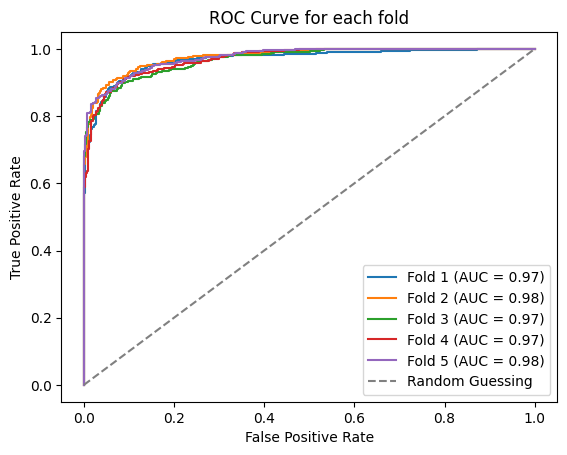

Average AUC across all folds: 0.9720103775795073




The accuracy for the 5 folds are:[0.9129554655870445, 0.9159919028340081, 0.8987854251012146, 0.9048582995951417, 0.9098277608915907]
The precision for the 5 folds are:[0.927487352445194, 0.9270315091210614, 0.9147157190635451, 0.9158249158249159, 0.9258010118043845]
The recall for the 5 folds are:[0.927487352445194, 0.9347826086956522, 0.9177852348993288, 0.9251700680272109, 0.9242424242424242]
The f1_score for the 5 folds are:[0.927487352445194, 0.9308909242298085, 0.9162479061976548, 0.9204737732656516, 0.9250210614995786]


Average Accuracy across all folds: 0.9084837708017999
Standard Deviation of Accuracy across all folds: 0.006088946723782025
Average Precision across all folds: 0.9221721016518203
Standard Deviation of Precision across all folds: 0.005673079059345967
Average Recall across all folds: 0.925893537661962
Standard Deviation of Recall across all folds: 0.005487257729182192
Average F1 Score across all folds: 0.9240242

In [110]:


y_train_lr = train_label_lr.values.flatten()

# Defining the number of folds for cross-validation
n_folds = 5
skf = StratifiedKFold(n_splits=n_folds)

# Initializing lists to store the true positive rate (tpr), the area under the curve (auc), 
# accuracy, precision, recall, and F1 score for each fold
tpr_list = []
auc_list = []
accuracy_list = []
precision_list = []
recall_list = []
f1_score_list = []

# Performing 5-fold cross-validation
for i, (train_index, test_index) in enumerate(skf.split(X_train, y_train)):
    X_train_fold, X_test_fold = data_train_features.iloc[train_index], data_train_features.iloc[test_index]
    y_train_fold, y_test_fold = y_train_lr[train_index], y_train_lr[test_index]

    
    # Training logistic regression model
    model = LogisticRegression()
    model.fit(X_train_fold, y_train_fold)
    
    # Predicting probabilities for the test set
    y_prob = model.predict_proba(X_test_fold)[:, 1]
    
    # Computing ROC curve
    fpr, tpr, thresholds = roc_curve(y_test_fold, y_prob)
    tpr_list.append(tpr)
    
    # Computing Area Under the Curve (AUC)
    auc_score = auc(fpr, tpr)
    auc_list.append(auc_score)
    
    # Calculating predictions
    y_pred = model.predict(X_test_fold)
    
    # Calculating accuracy
    accuracy = accuracy_score(y_test_fold, y_pred)
    accuracy_list.append(accuracy)
    
    # Calculating precision
    precision = precision_score(y_test_fold, y_pred)
    precision_list.append(precision)
    
    # Calculating recall
    recall = recall_score(y_test_fold, y_pred)
    recall_list.append(recall)
    
    # Calculating F1 score
    f1 = f1_score(y_test_fold, y_pred)
    f1_score_list.append(f1)
    
    # Plotting ROC curve
    plt.plot(fpr, tpr, label=f'Fold {i+1} (AUC = {auc_score:.2f})')

# Plotting ROC curve for each fold
plt.plot([0, 1], [0, 1], linestyle='--', color='grey', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for each fold')
plt.legend()
plt.show()

# Computing average AUC across all folds
avg_auc = np.mean(auc_list)
print("Average AUC across all folds:", avg_auc)
print('\n')

# Computing average and standard deviation of accuracy, precision, recall, and F1 score
avg_accuracy = np.mean(accuracy_list)
std_accuracy = np.std(accuracy_list)
avg_precision = np.mean(precision_list)
std_precision = np.std(precision_list)
avg_recall = np.mean(recall_list)
std_recall = np.std(recall_list)
avg_f1_score = np.mean(f1_score_list)
std_f1_score = np.std(f1_score_list)

print('\n')


print(f'The accuracy for the 5 folds are:{accuracy_list}')
print(f'The precision for the 5 folds are:{precision_list}')
print(f'The recall for the 5 folds are:{recall_list}')
print(f'The f1_score for the 5 folds are:{f1_score_list}')

print('\n')


print("Average Accuracy across all folds:", avg_accuracy)
print("Standard Deviation of Accuracy across all folds:", std_accuracy)
print("Average Precision across all folds:", avg_precision)
print("Standard Deviation of Precision across all folds:", std_precision)
print("Average Recall across all folds:", avg_recall)
print("Standard Deviation of Recall across all folds:", std_recall)
print("Average F1 Score across all folds:", avg_f1_score)
print("Standard Deviation of F1 Score across all folds:", std_f1_score)


The results of logisctic model is inline with the standard library lodictic regression. It is evident by ROC curve and accuracy, precision, recall and f1-score value.

<span style="font-size:40px;">Testing Linear Regression</span>

In [111]:
#importing the test data
data_test=pd.read_csv('data_test.csv')

data_test.shape

(3221, 12)

In [112]:
print(data_test.head())

   Unnamed: 0  NMHC(GT)  C6H6(GT)  PT08.S2(NMHC)  NOx(GT)  PT08.S3(NOx)  \
0           0    -200.0       8.0          898.0    122.0         933.0   
1           1    -200.0      19.4         1281.0   -200.0         774.0   
2           2    -200.0       9.9          975.0    349.0         638.0   
3           3    -200.0      12.7         1075.0    103.0         749.0   
4           4    -200.0       2.9          647.0    131.0        1054.0   

   NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)     T    RH      AH  
0    105.0        1594.0       1098.0  17.0  51.7  0.9914  
1   -200.0        1952.0       1324.0  20.8  43.6  1.0614  
2    223.0        1243.0       1064.0   5.6  74.6  0.6826  
3     98.0        1690.0       1022.0  31.7  21.5  0.9902  
4     85.0         962.0        828.0   8.4  54.5  0.6022  


In [113]:
data_test.isnull().sum()

Unnamed: 0        0
NMHC(GT)         37
C6H6(GT)         37
PT08.S2(NMHC)    37
NOx(GT)          37
PT08.S3(NOx)     37
NO2(GT)          37
PT08.S4(NO2)     37
PT08.S5(O3)      37
T                37
RH               37
AH               37
dtype: int64

In [114]:
# Removing rows with any null values
data_test.dropna(axis=0, how='any', inplace=True)

# Reseting indices of the DataFrame
data_test.reset_index(drop=True, inplace=True)

In [115]:
data_test.head()

,Unnamed: 0,NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,0,-200.0,8.0,898.0,122.0,933.0,105.0,1594.0,1098.0,17.0,51.7,0.9914
1,1,-200.0,19.4,1281.0,-200.0,774.0,-200.0,1952.0,1324.0,20.8,43.6,1.0614
2,2,-200.0,9.9,975.0,349.0,638.0,223.0,1243.0,1064.0,5.6,74.6,0.6826
3,3,-200.0,12.7,1075.0,103.0,749.0,98.0,1690.0,1022.0,31.7,21.5,0.9902
4,4,-200.0,2.9,647.0,131.0,1054.0,85.0,962.0,828.0,8.4,54.5,0.6022


In [116]:
#removing the unwanted columns
data_test = data_test.drop(['Unnamed: 0'], axis=1)

In [117]:
data_test.head()

,NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,-200.0,8.0,898.0,122.0,933.0,105.0,1594.0,1098.0,17.0,51.7,0.9914
1,-200.0,19.4,1281.0,-200.0,774.0,-200.0,1952.0,1324.0,20.8,43.6,1.0614
2,-200.0,9.9,975.0,349.0,638.0,223.0,1243.0,1064.0,5.6,74.6,0.6826
3,-200.0,12.7,1075.0,103.0,749.0,98.0,1690.0,1022.0,31.7,21.5,0.9902
4,-200.0,2.9,647.0,131.0,1054.0,85.0,962.0,828.0,8.4,54.5,0.6022


In [118]:
# Normalizing the test data using the same scaler
data_test_normalized = scaler.transform(data_test)

In [119]:
#Adding the bias term to the test data
data_test_normalized_bias = add_bias_term(data_test_normalized)

In [120]:
theta_lin_reg=linear_regression_closed_form(data_train_features_bias, data_train_label)
predictions_lin_reg=predict_lin_reg(data_test_normalized_bias, theta_lin_reg)

In [121]:
print(predictions_lin_reg)

[1083.95695129 1262.92454193 1150.78749035 ...  832.51824715 1003.98813607
 1077.30936006]


<span style="font-size:40px;">Testing Logistic regression model</span>

In [122]:



theta_train = np.zeros(data_train_features_bias.shape[1])
# Performing gradient descent
theta_train, _ = gradient_descent(data_train_features_bias_log_reg, train_label_lr.values.flatten(), theta_train, alpha, iterations)
# Making predictions
y_pred_test = predict_log_reg(data_test_normalized_bias, theta_train)
print(len(y_pred_test))

3184


In [123]:
print(y_pred_test)


[ True  True  True ... False False  True]


In [124]:


# Creating a DataFrame to store the predictions
predictions_df = pd.DataFrame({
    'pred_linear': predictions_lin_reg,
    'pred_logistic': y_pred_test.astype(int)  
})

# Saving the DataFrame to a CSV file
predictions_df.to_csv('predictions_pankaj.csv', index=False)
